# Machine Learning On Features

In [256]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os

print(os.getcwd())
repo_root = os.path.dirname(os.getcwd())
print(repo_root)
src_path = os.path.join(repo_root, 'src')
print(src_path)
os.sys.path.append(src_path)
if src_path not in os.sys.path:
    os.sys.path.append(src_path)

import features as ft

c:\Users\leona\OneDrive\Documents\Alpha Factor Research\ml-alpha-factor-research\notebooks
c:\Users\leona\OneDrive\Documents\Alpha Factor Research\ml-alpha-factor-research
c:\Users\leona\OneDrive\Documents\Alpha Factor Research\ml-alpha-factor-research\src


Again we load the data for the GOOGL ticker

In [257]:
def fetch_stock_data(ticker, start_date, end_date):
    # Fetch stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(years=15)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

print(end_date, start_date)

df_googl = fetch_stock_data('GOOGL', start_date, end_date)
print(df_googl.head())

2025-08-26 00:00:00 2010-08-26 00:00:00


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL      GOOGL
Date                                                             
2010-08-26  11.218505  11.374725  11.205072  11.344875   71008920
2010-08-27  11.413780  11.442636  11.135668  11.257809   92403504
2010-08-30  11.261042  11.436913  11.254325  11.421739   49206744
2010-08-31  11.194624  11.315272  11.144375  11.196863   77794128
2010-09-01  11.451095  11.565772  11.256317  11.318009  129002868


In [258]:
df_features = pd.DataFrame(index=df_googl.index)
close_price = df_googl['Close']
volume = df_googl['Volume']

df_features['mom_5'] = ft.momentum(close_price, 5)
df_features['mom_10'] = ft.momentum(close_price, 10)
df_features['mom_15'] = ft.momentum(close_price, 15)


df_features['volat_5'] = ft.roll_volatility(close_price, 5)
df_features['volat_10'] = ft.roll_volatility(close_price, 10)
df_features['volat_15'] = ft.roll_volatility(close_price, 15)

df_features['ma_ratio_5'] = ft.MA_ratio(close_price, 5)
df_features['ma_ratio_10'] = ft.MA_ratio(close_price, 10)
df_features['ma_ratio_15'] = ft.MA_ratio(close_price, 15)

df_features['z_score_5'] = ft.z_score(close_price, 5)
df_features['z_score_10'] = ft.z_score(close_price, 10)
df_features['z_score_15'] = ft.z_score(close_price, 15)

df_features['vol_z_score_5'] = ft.z_score(volume, 5)
df_features['vol_z_score_10'] = ft.z_score(volume, 10)
df_features['vol_z_score_15'] = ft.z_score(volume, 15)

df_features['RSI_5'] = ft.RSI(close_price, 5)
df_features['RSI_10'] = ft.RSI(close_price, 10)
df_features['RSI_15'] = ft.RSI(close_price, 15)

df_features['vol_spike_5'] = ft.vol_spike(volume, 5)
df_features['vol_spike_10'] = ft.vol_spike(volume, 10)
df_features['vol_spike_15'] = ft.vol_spike(volume, 15)

df_features['vol_mom_5'] = ft.momentum(volume, 5)
df_features['vol_mom_10'] = ft.momentum(volume, 10)
df_features['vol_mom_15'] = ft.momentum(volume, 15)

df_features.dropna(inplace=True)
print(df_features.head())




               mom_5    mom_10    mom_15   volat_5  volat_10  volat_15  \
Date                                                                     
2010-09-17  0.029424  0.058228  0.086855  0.009579  0.010129  0.011512   
2010-09-20  0.053933  0.080757  0.107774  0.017109  0.013988  0.013822   
2010-09-21  0.068751  0.105642  0.134242  0.015181  0.012007  0.012636   
2010-09-22  0.073569  0.096519  0.146616  0.014322  0.012054  0.012049   
2010-09-23  0.067393  0.078332  0.115461  0.015831  0.012800  0.011932   

            ma_ratio_5  ma_ratio_10  ma_ratio_15  z_score_5  ...  \
Date                                                         ...   
2010-09-17    1.014992     1.027105     1.041808   1.761758  ...   
2010-09-20    1.041318     1.056687     1.072826   1.681432  ...   
2010-09-21    1.037884     1.056678     1.074571   1.222080  ...   
2010-09-22    1.028319     1.052071     1.070036   0.924280  ...   
2010-09-23    1.010243     1.039032     1.057044   0.495157  ...   

    

We now need to prepare our target data. We have a classification problem, so our data should be a binary dataset. We will set a forecasting horizon of $K$ days. A 1 will represent if $P_{t+K} > P_{t}$ and a 0 will represent $P_{t+K} \le P_{t}$.

In [259]:
def make_classification_target(close: pd.Series, horizon: int) -> pd.DataFrame:
    """
    Create forward return and binary classification target from a price series.

    Parameters
    ----------
    close : pd.Series
        Series of closing prices, indexed by date.
    horizon : int, default 5
        Forecast horizon in days (e.g., 1 = next day, 5 = next week).

    Returns
    -------
    target_df : pd.DataFrame
        DataFrame with:
            'futret_<horizon>' : forward return over the horizon
            'target'           : binary label (1 if up, 0 if down or flat)
    """
    # Forward return
    futret = close.shift(-horizon) / close - 1
    futret_name = f"futret_{horizon}"

    # Binary target: 1 if forward return > 0, else 0
    target = (futret > 0).astype(int)

    # Combine into DataFrame
    target_df = pd.DataFrame({
        futret_name: futret,
        "target": target
    }, index=close.index)

    # Drop last horizon rows with NaNs in forward return
    target_df = target_df.dropna(subset=["target"])

    return target_df


In [260]:
ser_close = close_price['GOOGL']
df_ret = make_classification_target(ser_close, horizon=5)
print(df_ret.head(10))
ret_adj = df_ret[15:]
print(df_features.tail())
print(df_features.tail())

df_features.dropna(inplace=True)
print(df_features.tail())
#df_features.drop(columns=['futret_1'], inplace=True)
print(df_features.tail())


            futret_5  target
Date                        
2010-08-26  0.027052       1
2010-08-27  0.024998       1
2010-08-30  0.025868       1
2010-08-31  0.045687       1
2010-09-01  0.034432       1
2010-09-02  0.027980       1
2010-09-03  0.025452       1
2010-09-07  0.034518       1
2010-09-08  0.021378       1
2010-09-09  0.010248       1
               mom_5    mom_10    mom_15   volat_5  volat_10  volat_15  \
Date                                                                     
2025-08-19 -0.008705  0.035445  0.029732  0.006535  0.009891  0.013892   
2025-08-20 -0.013072  0.016472  0.014196  0.007589  0.010792  0.014286   
2025-08-21 -0.015719  0.016436  0.040907  0.007000  0.010792  0.012563   
2025-08-22  0.010741  0.023185  0.089674  0.017356  0.012501  0.013661   
2025-08-25  0.024521  0.037264  0.068960  0.017594  0.012710  0.011876   

            ma_ratio_5  ma_ratio_10  ma_ratio_15  z_score_5  ...  \
Date                                                         ... 

The baseline model to test other models agaianst will be a logistic regression model which we will now implement

In [261]:
df_features['futret_1'] = df_ret['target']
X = df_features.iloc[:, :-1] # All columns except the last one
y = df_features.iloc[:, -1] # Last column as target
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [262]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [263]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_val = pipe.predict(X_val)
y_pred_val_prob = pipe.predict_proba(X_val)[:,1]
y_pred_val_bin = (y_pred_val_prob > 0.55).astype(int)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_bin))
print("Validation ROC AUC:", roc_auc_score(y_val, y_pred_val_prob))

Validation Accuracy: 0.49134487350199735
Validation ROC AUC: 0.46314827006071246


{'importances_mean': array([-0.00865513,  0.00479361, -0.00852197, -0.00208611,  0.00261873,
        0.01580115,  0.00261873, -0.00235242,  0.00665779,  0.00044385,
       -0.01699956, -0.01047492,  0.01131824, -0.00980914,  0.01207279,
       -0.00039947,  0.00479361,  0.00772304,  0.00257435, -0.00372836,
        0.00705726, -0.00062139, -0.00075455, -0.00057701]), 'importances_std': array([0.00909465, 0.00773833, 0.00894955, 0.00730687, 0.00936824,
       0.01087068, 0.00553821, 0.00720916, 0.00638593, 0.00843086,
       0.0071598 , 0.00497907, 0.0056676 , 0.00879556, 0.00613031,
       0.00875965, 0.00589105, 0.00820395, 0.00860158, 0.00605725,
       0.00541591, 0.00816303, 0.00855162, 0.00715154]), 'importances': array([[-0.00798935, -0.00532623,  0.00798935, -0.02929427, -0.00266312,
        -0.01731025, -0.01198402,  0.        ,  0.01464714, -0.01731025,
        -0.00798935, -0.01731025, -0.01331558, -0.01198402, -0.00932091,
        -0.01731025,  0.00133156, -0.00266312, -0.02

<BarContainer object of 24 artists>

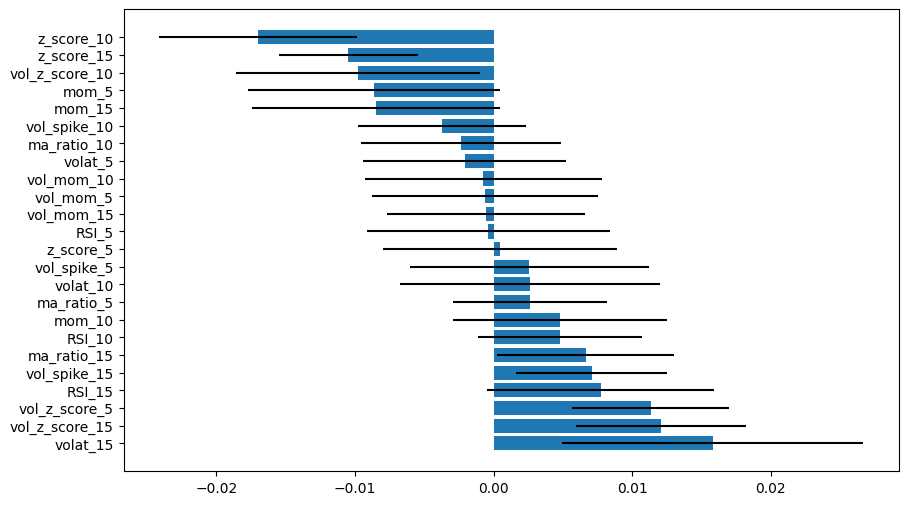

In [281]:
from sklearn.inspection import permutation_importance
result = permutation_importance(pipe, X_val, y_val, n_repeats=30, random_state=42)
print(result)

perm_df =  pd.DataFrame({
    'feature': X_val.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
}).sort_values(by='importance', ascending=False)

print(perm_df.head(10))
plt.figure(figsize=(10, 6))
plt.barh(perm_df['feature'], perm_df['importance'], xerr=perm_df['std'])

The permutation importance measures the accruacy drop when rnadomly shiffling a feature. This breaks the time order of the feature so that it becomes redundant. This is done multiple times for each feature to gain an anvergae and a standard deviation on the accuracy drop.

Before dropping the weekest features however, a correlation check needs to be conducted between the features.

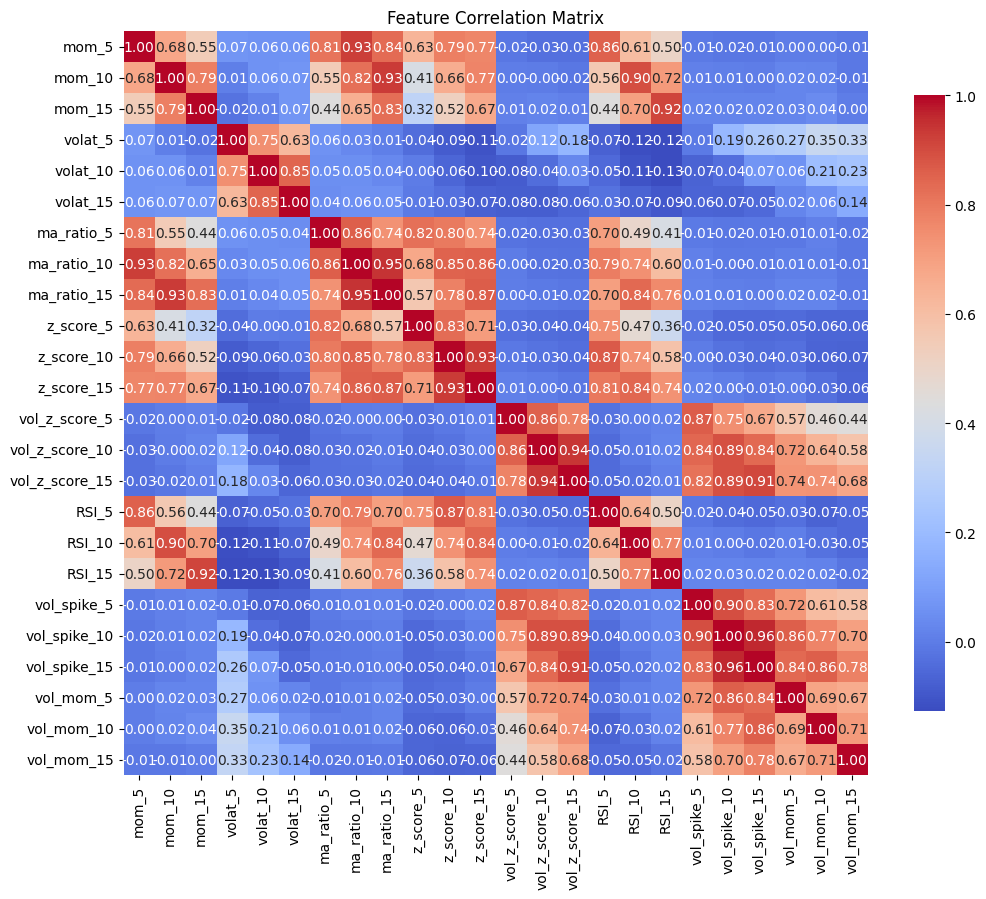

In [265]:
import seaborn as sns

X_corr = X_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(X_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.show()

In [266]:
def feat_select(corr_mat: pd.DataFrame, importances: pd.DataFrame, threshold: float = 0.85) -> list:
    """
    Select features based on permutation importance.
    Parameters
    ----------
    importances : pd.DataFrame
        DataFrame with 'feature', 'importance', and 'std' columns.
    threshold : float, default 0.85
    Returns
    -------
    selected_features : list
        List of selected feature names and dropout features.
    """
    features = importances.iloc[:,0]
    feat_set = set(features)
    drop_features = []

    while feat_set:
        feat = feat_set.pop()
        sieve = corr_mat[feat] > threshold # Booleans that correspond to features correlated with current feature 
        high_corr = corr_mat.index[sieve] # Highly correlated features
        high_corr_set = set(high_corr) # Set of highly correlated features
        high_corr_set.add(feat)
        sub_features  = importances[importances['feature'].isin(high_corr_set)] # Subset of features that are highly correlated with the current feature
        best_feature = sub_features.sort_values(by='importance', ascending=False).iloc[0] # Best feature based on importance
        high_corr_set.remove(best_feature['feature'])
        drop_features.extend(list(high_corr_set))
        feat_set -= high_corr_set

    selected_features = [feat for feat in features if feat not in drop_features]
    return selected_features, drop_features

sel_feat, drop_feat = feat_select(X_corr.abs(), perm_df, threshold=0.85)
print("Selected feature Length:", len(sel_feat))
print("Dropped feature Length:", len(drop_feat))


Selected feature Length: 9
Dropped feature Length: 25


In [267]:
df_selected = df_features[sel_feat]
df_selected['target'] = df_features.iloc[:,-1]
#print(df_selected.head())
print(df_features.iloc[:,-1].head())

X = df_selected.iloc[:, :-1] # All columns except the last one
y = df_selected.iloc[:, -1] # Last column as target
print(y)
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)
X_train_corr, X_val_corr, X_test_corr = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

Date
2010-09-17    1
2010-09-20    1
2010-09-21    1
2010-09-22    1
2010-09-23    1
Name: futret_1, dtype: int64
Date
2010-09-17    1
2010-09-20    1
2010-09-21    1
2010-09-22    1
2010-09-23    1
             ..
2025-08-19    0
2025-08-20    0
2025-08-21    0
2025-08-22    0
2025-08-25    0
Name: target, Length: 3757, dtype: int64


In [268]:


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs'))
])

pipe.fit(X_train_corr, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

In [269]:
y_pred_val = pipe.predict(X_val_corr)
y_pred_val_prob = pipe.predict_proba(X_val_corr)[:,1]
y_pred_val_bin = (y_pred_val_prob > 0.55).astype(int)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_bin))
print("Validation ROC AUC:", roc_auc_score(y_val, y_pred_val_prob))

Validation Accuracy: 0.521970705725699
Validation ROC AUC: 0.4814132104454685


The model implemented is not adequsate for the data. This is to be expected as time series is completely heavily non-linear

In [270]:
from xgboost import XGBClassifier

n_estimators = 500
learning_rate = 0.1
max_depth = 4
subsample = 0.8
cosample_bytree = 0.8
use_label_encoder=False
eval_metric='auc'


pipe = Pipeline([

    ('xgb', XGBClassifier(n_estimators=n_estimators,
                          learning_rate=learning_rate,
                          max_depth=max_depth,
                          subsample=subsample,
                          colsample_bytree=cosample_bytree,
                          use_label_encoder=use_label_encoder,
                          eval_metric=eval_metric))
])

In [271]:
pipe.fit(X_train, y_train)
y_pred_val = pipe.predict(X_val)
y_pred_val_prob = pipe.predict_proba(X_val)[:,1]
y_pred_val_bin = (y_pred_val_prob > 0.55).astype(int)
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val_bin))
print("Validation ROC AUC:", roc_auc_score(y_val, y_pred_val_prob))

Validation Accuracy: 0.4793608521970706
Validation ROC AUC: 0.4636603028308097


In [ ]:
from tqdm import tqdm_notebook

def optimise_params(hyper_params):
    results = []
    
    for params in tqdm_notebook(hyper_params):
        lr, n_est = params
        pipe = Pipeline([
            ('xgb', XGBClassifier(n_estimators=n_est,
                                  learning_rate=lr,
                                  max_depth=max_depth,
                                  subsample=subsample,
                                  colsample_bytree=cosample_bytree,
                                  use_label_encoder=use_label_encoder,
                                  eval_metric=eval_metric))
        ])
        
        pipe.fit(X_train_corr, y_train)
        y_pred_val_prob = pipe.predict_proba(X_val_corr)[:,1]
        val_acc = accuracy_score(y_val, (y_pred_val_prob > 0.55).astype(int))
        roc_auc = roc_auc_score(y_val, y_pred_val_prob)
        results.append((params, val_acc, roc_auc))
    
    results_df = pd.DataFrame(results, columns=['Params(lr, n_est)', 'val_acc', 'roc_auc'])
    results_df = results_df.sort_values(by='roc_auc', ascending=False).reset_index(drop=True)
    return results_df
    


In [ ]:
import itertools
import warnings
warnings.filterwarnings('ignore')

l_rate = np.arange(0.01, 0.11, 0.01)
n_est = np.arange(500, 1001, 50)
h_params = list(itertools.product(l_rate, n_est))

df_results = optimise_params(h_params)
df_results

  0%|          | 0/110 [00:00<?, ?it/s]

,"Params(lr, n_est)",val_acc,roc_auc
0,"(0.09, 950)",0.519308,0.514966
1,"(0.09, 1000)",0.519308,0.514849
2,"(0.09, 800)",0.516644,0.514483
3,"(0.09, 900)",0.517976,0.514293
4,"(0.09999999999999999, 950)",0.511318,0.513869
...,...,...,...
105,"(0.01, 650)",0.491345,0.470785
106,"(0.01, 700)",0.491345,0.470046
107,"(0.01, 600)",0.486019,0.469805
108,"(0.01, 550)",0.480692,0.469183


In [280]:
print(X_train_corr)

            ma_ratio_15  vol_spike_10     mom_5  volat_10  volat_15    mom_15  \
Date                                                                            
2010-09-17     1.041808      2.209888  0.029424  0.010129  0.011512  0.086855   
2010-09-20     1.072826      1.607586  0.053933  0.013988  0.013822  0.107774   
2010-09-21     1.074571      1.481438  0.068751  0.012007  0.012636  0.134242   
2010-09-22     1.070036      0.837777  0.073569  0.012054  0.012049  0.146616   
2010-09-23     1.057044      0.768101  0.067393  0.012800  0.011932  0.115461   
...                 ...           ...       ...       ...       ...       ...   
2019-08-26     0.991522      0.843717 -0.024374  0.018259  0.017352  0.014228   
2019-08-27     0.991231      0.954077 -0.010739  0.016998  0.016973 -0.000222   
2019-08-28     0.993833      0.739642 -0.014963  0.014545  0.016950 -0.001837   
2019-08-29     1.011865      0.899076  0.002283  0.015452  0.016168 -0.009907   
2019-08-30     1.008629     